In [1]:
import gdown
!rm -r /content/sample_data # i hate a lot this folder
path = 'https://drive.google.com/file/d/159TvOcNq6C2KMHA5Mt3V0z3GTNzzj9Hh/view?usp=share_link'
link = path.split('/')
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={link[-2]}",
    'heartdatatrain.zip'
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=159TvOcNq6C2KMHA5Mt3V0z3GTNzzj9Hh
To: /content/heartdatatrain.zip
100%|██████████| 128M/128M [00:10<00:00, 11.7MB/s]


'heartdatatrain.zip'

In [2]:
%%capture
!unzip heartdatatrain.zip

In [3]:
%%capture
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install wandb

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
import pandas as pd
import cv2
import numpy as np
from numpy import load
import albumentations as A
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from fastprogress import master_bar, progress_bar
import wandb
print('albumentations :', A.__version__)
print('pytorch_lightning :', pl.__version__)
print("torch :", torch.__version__)

albumentations : 1.2.1
pytorch_lightning : 1.8.6
torch : 1.13.0+cu116


In [5]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        #self.train = train
        self.transforms = transforms
        self.num_classes = 4

        #sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "mask")
        val_split = 2419 #2419
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
            #image_file_names.append(files)
        if train:
          self.images = sorted(image_file_names)[:val_split]
        else:
          self.images = sorted(image_file_names)[val_split:]

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
            #annotation_file_names.append(files)
        if train:
          self.annotations = sorted(annotation_file_names)[:val_split]
        else:
          self.annotations = sorted(annotation_file_names)[val_split:]
          
        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        
        
        if self.transforms:
            t = self.transforms(image=image, mask=segmentation_map)
            img = t['image']
            mask = t['mask'] 

        img_t = torch.from_numpy(img).float().unsqueeze(0)
        #img_t = (img_t/ 127.5)-1
        # mask encoding
        mask_oh = torch.nn.functional.one_hot(torch.from_numpy(mask).long(), self.num_classes).permute(2,0,1).float()
        return img_t, mask_oh


In [17]:
class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=2, num_workers=0, pin_memory=False, random_state=42):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.random_state = random_state
        WIDTH = 224
        HEIGHT = 224
        self.root_dir = 'data_train'
        self.transform = A.Compose([
                         A.Normalize(mean=(0.485,), std=(0.229,)),
                         A.Resize(WIDTH,HEIGHT),
                         A.Flip(p=0.5),
                         A.RandomBrightnessContrast(p=0.2),
                        ])
        self.Notrans =   A.Compose([
                         A.Normalize(mean=(0.485,), std=(0.229,)),
                         A.Resize(WIDTH,HEIGHT), 
                        ])                

    def setup(self, stage=None):
        
        self.train_dataset = ImageSegmentationDataset(root_dir=self.root_dir, transforms=self.transform)
        self.val_dataset = ImageSegmentationDataset(root_dir=self.root_dir,  transforms=self.Notrans, train=False)
        print("Training size:", len(self.train_dataset))
        print("Testing size:",len(self.val_dataset))

    def get_dataloader(self, ds, batch_size=None, shuffle=None):
        return DataLoader(
            ds,
            batch_size=batch_size if batch_size is not None else self.batch_size,
            shuffle=shuffle if shuffle is not None else True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        ) if ds is not None else None

    def train_dataloader(self, batch_size=None, shuffle=True):
        return self.get_dataloader(self.train_dataset, batch_size, shuffle)

    def val_dataloader(self, batch_size=None, shuffle=False):
        return self.get_dataloader(self.val_dataset, batch_size, shuffle)

In [18]:
dm = DataModule()
dm.setup()

Training size: 2419
Testing size: 605


In [19]:
ima, labels = next(iter(dm.train_dataloader(batch_size=2)))
ima.shape, ima.dtype,  torch.max(ima) , torch.min(ima), labels.shape, labels.dtype

(torch.Size([2, 1, 224, 224]),
 torch.float32,
 tensor(1.9732),
 tensor(-2.1179),
 torch.Size([2, 4, 224, 224]),
 torch.float32)

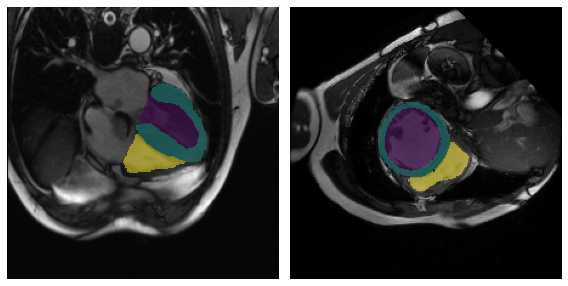

In [26]:
i, m = next(iter(dm.train_dataloader(batch_size=2)))
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
for idx in range(2):
    image = i[idx][0]
    axs[idx].imshow(image, cmap="gray")
    mask = torch.argmax(m[idx], axis=0).float().numpy()
    mask[mask == 0] = np.nan
    axs[idx].imshow(mask, alpha=0.5)
    axs[idx].axis('off')
plt.tight_layout()
plt.show()

In [27]:
import torch.nn.functional as F
class BaseModule(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        self.save_hyperparameters(hparams)

    def forward(self, x):
        raise NotImplementedError

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self(x)

    def compute_loss(self, y_hat, y):

        loss = F.binary_cross_entropy_with_logits(y_hat, y) #BCELoss
        return loss

    def compute_IoU(self, pr, gt, th=0.5, eps=1e-7):
        pr = torch.sigmoid(pr) > th
        gt = gt > th
        intersection = torch.sum(gt * pr, axis=(-2,-1))
        union = torch.sum(gt, axis=(-2,-1)) + torch.sum(pr, axis=(-2,-1)) - intersection + eps
        ious = (intersection + eps) / union
        return torch.mean(ious).item()


    def shared_step(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        metric = self.compute_IoU(y_hat, y)
        return loss, metric
        
    def training_step(self, batch, batch_idx):
        loss, metric = self.shared_step(batch)
        self.log('loss', loss)
        self.log('metric', metric, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, metric = self.shared_step(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_metric', metric, prog_bar=True)

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer)(
            self.parameters(), **self.hparams['optimizer_params'])
        if 'scheduler' in self.hparams:
            schedulers = [
                getattr(torch.optim.lr_scheduler, scheduler)(
                    optimizer, **params)
                for scheduler, params in self.hparams.scheduler.items()
            ]
            return [optimizer], schedulers
        return optimizer

In [28]:
import segmentation_models_pytorch as smp
class Unet(BaseModule):
    def __init__(self, hparams=None):
        super().__init__(hparams)
        self.model = smp.Unet(
            encoder_name = self.hparams.encoder_name,
            encoder_weights =  self.hparams.encoder_weights,
            in_channels = self.hparams.in_channels,
            classes= self.hparams.classes,
        )

    def forward(self, pixel_values):
        out = self.model(pixel_values)
        return (out)

In [29]:
# choose encoder, e.g. 
# resnet18, resnet34, resnet101,  
# mobilenet_v2 or efficientnet-b7, efficientnet-b5
hparams = {
    'encoder_name': 'resnet18', 
    'encoder_weights': 'imagenet',
    'in_channels': 1,
    'classes': 4,
}
model = Unet(hparams)
outputs = model(i)
outputs.shape

torch.Size([2, 4, 224, 224])

In [31]:

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
path_checkpoints = "/content/checkpoints" 
config = {
    'encoder_name': 'resnet18', 
    'encoder_weights': 'imagenet',
    'in_channels': 1,
    'classes': 4,
    'optimizer': 'Adam',
    'optimizer_params': {
        'lr': 0.00005
    },
    'scheduler': {
        'OneCycleLR':{
            'pct_start': 0.01,
            'max_lr': 0.0005,
            'steps_per_epoch': 49,
            'epochs': 50,
            'verbose': False
        } 
    },

    'trainer': {  
        'gpus': 1,
        'max_epochs': 50,
        'logger': True,
        'enable_checkpointing': False,
        'overfit_batches': 0,
        'deterministic': True, #it's NOT working, you must to keep False
        'precision': 16,
        'log_every_n_steps': 64
    },
    'datamodule': {
        'batch_size': 64,
        'num_workers': 0,
        'pin_memory': True 
    },
}

def train(config, name):
    pl.seed_everything(21, workers=True)
    dm = DataModule(**config['datamodule'])

    module = Unet(config)

    config['trainer']['callbacks'] = []
    if config['trainer']['enable_checkpointing']:
        config['trainer']['callbacks'] += [
            ModelCheckpoint(
                dirpath = path_checkpoints,
                filename=f'{name}-{{val_metric:.5f}}-{{epoch}}',
                monitor='val_metric',
                mode='max',
                save_top_k=1
            ),
            ModelCheckpoint( # i think it's all you need to Checkpointed the model in each epoch
                dirpath = path_checkpoints,
                filename=f'{name}-{{epoch}}',
                monitor='epoch',
                mode='max',
                save_top_k=1
            )
        ]
    if config['trainer']['logger']:
        config['trainer']['logger'] = WandbLogger(
            project="Unet",
            name=name,
            config=config
        )
        if 'scheduler' in config and config['scheduler']:
            config['trainer']['callbacks'] += [
                LearningRateMonitor(logging_interval='step')]

    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)

In [15]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
train(config, "Unet/resnet18_nor_")

INFO:lightning_lite.utilities.seed:Global seed set to 21
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Unet | 14.3 M
-------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
28.645    Total estimated model params size (MB)


Training size: 2419
Testing size: 605


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [30]:
wandb.finish()

epoch,▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█
loss,█▇▆▅▃▂▁
lr-Adam,▁▂▃▃▅▇█
metric,▁▂▄▄▆██
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁
val_metric,▄▂▃▁▁▂▂▄▆▇███
epoch,12
loss,0.18861
lr-Adam,0.00024
metric,0.39491


In [ ]:
# 19:49 mim val_iou 0.831 , 14.3 M de parámetros resnet18
# 21:35 mim val_iou 0.830 , 24.4 M de parámetros resnet34
# 32:53 mim val_iou 0.843 , 51.5 M de parámetros resnet101

In [ ]:
# Epoch 53/53 loss 0.0093 val_loss 0.0063 iou 0.8558 val_iou 0.8334 22 min ,11.7M de parámetros
# Epoch 48/50 loss 0.0107 val_loss 0.0079 iou 0.8503 val_iou 0.8240 20 min ,11.7M de parámetros resnet18
# Epoch 48/50 loss 0.2099 val_loss 0.2262 iou 0.2928 val_iou 0.3314 25 min ,11.7M de parámetros sin scheduler
# Epoch 53/53 loss 0.0100 val_loss 0.0069 iou 0.8546 val_iou 0.8369 25 min??? ,21.7M de parámetros resnet34
# Epoch 47/50 loss 0.0104 val_loss 0.0072 iou 0.8543 val_iou 0.8360 32 min ,21.7M de parámetros resnet34
# Epoch 52/53 loss 0.0094 val_loss 0.0070 iou 0.8613 val_iou 0.8414 53 min ,44.5M de parámetros resnet101
# Epoch 52/53 loss 0.0094 val_loss 0.0070 iou 0.8613 val_iou 0.8414 53 min ,44.5M de parámetros resnet101
# Epoch 49/50 loss 0.0104 val_loss 0.0075 iou 0.8527 val_iou 0.8292 63 min ,44.5M de parámetros resnet101

Epoch 53/53 loss 0.0093 val_loss 0.0063 iou 0.8558 val_iou 0.8334
22 minutos 

In [ ]:
!nvidia-smi

Thu Jan 12 19:21:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |  14092MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3a828ba0-6a4d-0c01-7c37-091551ac5dfb)


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
